In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
from IPython.display import Image
warnings.filterwarnings('ignore')
%matplotlib inline

### 問題1

##### 何を学習し、何を予測するのか

ローン契約(ID: SK_ID_CURR)の情報とその契約者の情報から、どういった場合そのローンが延滞されるのかを学習し、ローンが延滞される確率(TARGET 0 ~ 1, 1ほど延滞するリスクが高い)を予測する。

##### どのようなファイルを作りKaggleに提出するか

テストデータに対して予測した結果を以下のようにフォーマットにして提出する
```
SK_ID_CURR,TARGET
100001,0.1
100005,0.9
```

##### 提出されたものはどういった指標値で評価されるのか

予測確率と実際のTARGET値のROC曲線のエリア面積、つまりAUCの値で評価される

In [2]:
# 問題2 分析
df = pd.read_csv("data/credit/application_train.csv")
df_test = pd.read_csv("data/credit/application_test.csv")

In [3]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [5]:
# IDと目的関数削除
X = df.drop(["SK_ID_CURR", "TARGET"], axis=1)
y = df.loc[: ,["TARGET"]]

延滞したサンプルデータの割合: 8.07%


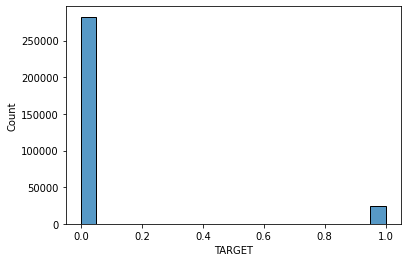

In [6]:
sns.histplot(df["TARGET"])
print("延滞したサンプルデータの割合: {:.2f}%".format(100 * (df["TARGET"] == 1).sum() / len(df)))

In [7]:
def display_null_info(X):
    print("欠損値を含むデータ数: {} (全体: {}, 割合: {})".format(len(X) - len(X.dropna()), len(X), (len(X) - len(X.dropna())) / len(X)))
    print("欠損値を含む項目数: {} (全体: {})".format((X.isnull().sum() > 0).sum(), len(X.columns)))
    pd.set_option('display.max_rows', 120)
    pd.DataFrame({'total':  X.isnull().sum(), 'missing_ratio': X.isnull().sum() / len(X)}).sort_values('total', ascending=False)
display_null_info(X)

欠損値を含むデータ数: 298909 (全体: 307511, 割合: 0.9720270169197199)
欠損値を含む項目数: 67 (全体: 120)


In [8]:
def display_null_info(X):
    print("欠損値を含むデータ数: {} (全体: {}, 割合: {})".format(len(X) - len(X.dropna()), len(X), (len(X) - len(X.dropna())) / len(X)))
    print("欠損値を含む項目数: {} (全体: {})".format((X.isnull().sum() > 0).sum(), len(X.columns)))
    pd.set_option('display.max_rows', 120)
    pd.DataFrame({'total':  X.isnull().sum(), 'missing_ratio': X.isnull().sum() / len(X)}).sort_values('total', ascending=False)
display_null_info(X)

欠損値を含むデータ数: 298909 (全体: 307511, 割合: 0.9720270169197199)
欠損値を含む項目数: 67 (全体: 120)


In [9]:
# カテゴリのユニーク値一覧表示
tmp = []
for column in X.select_dtypes(include=object):
    unique_values= ','.join([str(n) for n in X[column].unique()])
    tmp.append(pd.DataFrame({'column': [column], 'unique_values': [unique_values]}))
pd.concat(tmp).reset_index()

,index,column,unique_values
0,0,NAME_CONTRACT_TYPE,"Cash loans,Revolving loans"
1,0,CODE_GENDER,"M,F,XNA"
2,0,FLAG_OWN_CAR,"N,Y"
3,0,FLAG_OWN_REALTY,"Y,N"
4,0,NAME_TYPE_SUITE,"Unaccompanied,Family,Spouse, partner,Children,..."
5,0,NAME_INCOME_TYPE,"Working,State servant,Commercial associate,Pen..."
6,0,NAME_EDUCATION_TYPE,"Secondary / secondary special,Higher education..."
7,0,NAME_FAMILY_STATUS,"Single / not married,Married,Civil marriage,Wi..."
8,0,NAME_HOUSING_TYPE,"House / apartment,Rented apartment,With parent..."
9,0,OCCUPATION_TYPE,"Laborers,Core staff,Accountants,Managers,nan,D..."


### 考察
- 欠損値を一つでも持つデータが97%なので欠損のあるデータを全て削除する訳にはいかず補間が必要と考えられる


### 問題2に対しての前処理
1. 数値系データは平均で保管
2. それ以外の項目は削除
3. カテゴリカルデータはOHE
4. 数値は標準化

In [10]:
# 問題2
# 前処理1 数値データは平均で補完
X_only_num = X.select_dtypes(exclude=object)
X_means_only_num = X_only_num.mean()
X_only_num.fillna(X_means_only_num)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,1.000000
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
3,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,...,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974
4,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,-8456.0,-1982,...,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974
307507,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,365243,-4388.0,-4090,...,0,0,0,0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974
307508,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,-7921,-6737.0,-5150,...,0,0,0,0,1.000000,0.000,0.000000,1.000000,0.000000,1.000000
307509,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,-4786,-2562.0,-931,...,0,0,0,0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000


In [11]:
X[X_only_num.columns]= X_only_num.fillna(X_means_only_num)

In [12]:
display_null_info(X)

欠損値を含むデータ数: 241722 (全体: 307511, 割合: 0.7860596856697809)
欠損値を含む項目数: 6 (全体: 120)


In [13]:
(X.isnull().sum() > 0).index

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=120)

In [14]:
# 前処理2  欠損値を含む項目が6つなので6つを削除
print(X.shape)
X = X.dropna(axis=1)
print(X.shape)

(307511, 120)
(307511, 114)


In [15]:
# 前処理3 カテゴリデータにOHE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ohe = ColumnTransformer([("OneHotEncoder", OneHotEncoder(handle_unknown='ignore'),  X.select_dtypes(include=["object"]).columns)], remainder = 'passthrough')
X_ohe = X.copy()
ohe.fit(X_ohe)
X_ohe = ohe.transform(X_ohe)

In [16]:
# 前処理4 標準化
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X_ohe, y, random_state=123)
sc = StandardScaler(with_mean=False)
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def create_and_evaluate_model(X_train, X_test, y_train, y_test, model, model_name, graph=True):
    model.fit(X_train, y_train)
    target_pred = model.predict(X_test)
    fp_rate, tp_rate, threshold = roc_curve(y_test, target_pred)
    print('真陽性率： ', tp_rate)
    print('偽陽性率： ', fp_rate)
    if graph:
        fig, ax = plt.subplots()
        ax.step(fp_rate, tp_rate)
        ax.set_xlabel('fp rate')
        ax.set_ylabel('tp rate')
        plt.show()
    auc = roc_auc_score(y_test, target_pred)
    print("AUC: {}".format(auc))
    return model

真陽性率：  [0.00000000e+00 0.00000000e+00 1.59515074e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
偽陽性率：  [0.00000000e+00 1.41625005e-05 1.41625005e-05 ... 9.99107762e-01
 9.99136087e-01 1.00000000e+00]


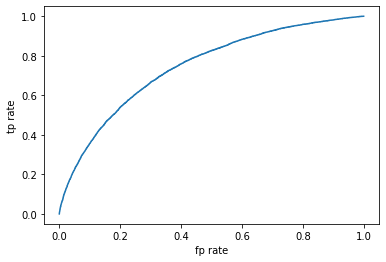

AUC: 0.7444299674977954


In [18]:
from sklearn.linear_model import LinearRegression
learned_model = create_and_evaluate_model(X_train, X_test, y_train, y_test, LinearRegression(), "Linear Regression")

In [19]:
display_null_info(df_test)

欠損値を含むデータ数: 47005 (全体: 48744, 割合: 0.9643238142130314)
欠損値を含む項目数: 64 (全体: 121)


In [20]:
# application testに対する前処理
X_t = df_test.drop(["SK_ID_CURR"], axis=1)
X_t_only_num =  X_t.select_dtypes(exclude=object)
# trainデータで利用した平均値でnullデータを置換
X_t[X_t_only_num.columns] = X_t_only_num.fillna(X_means_only_num)
# トレーニングデータで削除した欠損値を含むカラムを削除
X_t = X_t.drop(["NAME_TYPE_SUITE", "OCCUPATION_TYPE", "FONDKAPREMONT_MODE",  "HOUSETYPE_MODE", "WALLSMATERIAL_MODE", "EMERGENCYSTATE_MODE"], axis=1)
# トレーニングデータで使用したOHEでOHE
X_t_ohe = X_t.copy()
X_t_ohe = ohe.transform(X_t_ohe)
# トレーニングデータで使用したscで標準化
X_t_ohe = sc.transform(X_t_ohe)

In [21]:
# 問題3
pred_application_test = learned_model.predict(X_t_ohe).flatten()
# 0以下の予測値は0で置換
pred_application_test = np.where(pred_application_test < 0, 0, pred_application_test)
df_pred_application_test = pd.DataFrame({'SK_ID_CURR': df_test["SK_ID_CURR"], 'TARGET': pred_application_test})

In [22]:
df_pred_application_test.to_csv("result/credit/pred_application_test_01.csv", index=False)
df_pred_application_test.head()

,SK_ID_CURR,TARGET
0,100001,0.065269
1,100005,0.172569
2,100013,0.070900
3,100028,0.038536
4,100038,0.134087


## 問題3の結果

- アプローチ
数値データは平均値で補完し、それ以外の欠損のある項目は削除。カテゴリカルデータに対してOHE、数値データには標準化を適用し、線形回帰モデルでモデルを作成して予測した。0未満の予測値に対しては0で置換している。

- 結果

Score: 0.72991
Private score: 0.73563
    
順位不明、ランキング外

#### 問題4
- アプローチ1: カテゴリの欠損データを削除するのではなく、文字列で埋めて検証

In [23]:
# 初期化する関数
def init():
    df = pd.read_csv("data/credit/application_train.csv")
    df_test = pd.read_csv("data/credit/application_test.csv")
    X = df.drop(["SK_ID_CURR", "TARGET"], axis=1)
    y = df.loc[: ,["TARGET"]]
    return X, y

In [24]:
# グラフを見たい時の関数
def display_graphs(column_name):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    sns.histplot(df[column_name])
    plt.subplot(1,2,2)
    sns.histplot(train_df[train_df['TARGET']==0][column_name], label='not difficult payment')
    sns.histplot(train_df[train_df['TARGET']==1][column_name], label='difficult payment')
    plt.show()

In [48]:
# アプローチ1のclass
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA

class MLRunner01():
    def __init__(self, scaler=StandardScaler(with_mean=False), category_encode="ohe", num_missing_imputation="mean", pca=None):
        self.scaler = scaler
        self.category_encode = category_encode
        self.num_missing_imputation = num_missing_imputation
        self.pca = pca

    def preprocess_train_and_split_train_test(self, X_train, y_train):
        X = X_train.copy()
        y = y_train.copy()
        # 前処理1 数値データの欠損は平均 or 中央値で埋める
        X_only_num = X.select_dtypes(exclude=object)
        if self.num_missing_imputation == "mean":
            X_means = X_only_num.mean()
            self.num_missing_values = X_means
            X[X_only_num.columns] = X_only_num.fillna(X_means)
        elif self.num_missing_imputation == "median":
            X_medians = X_only_num.median()
            self.num_missing_values = X_medians
            X[X_only_num.columns] = X_only_num.fillna(X_medians)

        # 前処理2 カテゴリデータの欠損は"NAN"で埋める
        X_only_cate = X.select_dtypes(include=object)
        X[X_only_cate.columns] = X_only_cate.fillna("NAN")

        #  前処理3 カテゴリデータの欠損を埋める
        category_encoder = None
        if self.category_encode == "ohe":
            category_encoder = ColumnTransformer([("OneHotEncoder", OneHotEncoder(handle_unknown='ignore'),  X.select_dtypes(include=["object"]).columns)], remainder = 'passthrough')
        elif self.category_encode == "label":
            # 知らない値は-1で埋める
            category_encoder = ColumnTransformer([("OneHotEncoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),  X.select_dtypes(include=["object"]).columns)], remainder = 'passthrough')

        X_encoded = X.copy()
        category_encoder.fit(X_encoded)
        X_encoded = category_encoder.transform(X_encoded)
        self.category_encoder = category_encoder
        # 前処理4 標準化
        X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_encoded, y, random_state=123)
        self.scaler.fit(X_train_train)
        X_train_train = self.scaler.transform(X_train_train)
        X_train_test = self.scaler.transform(X_train_test)
        
        # 前処理5 PCA
        if self.pca is not None:
            self.pca.fit(X_train_train)
            X_train_train = self.pca.transform(X_train_train)
            X_train_test = self.pca.transform(X_train_test)

        return X_train_train, X_train_test, y_train_train, y_train_test

    def preprocess_test(self, X_test):
        X = X_test.copy()
        # 前処理1
        X_only_num = X.select_dtypes(exclude=object)
        X[X_only_num.columns] = X_only_num.fillna(self.num_missing_values)
        # 前処理2
        X_only_cate = X.select_dtypes(include=object)
        X[X_only_cate.columns] = X_only_cate.fillna("NAN")
        # 前処理3
        X = self.category_encoder.transform(X)
        # 前処理4
        X = self.scaler.transform(X)
        # 前処理5
        if self.pca is not None:
            X = self.pca.transform(X)
        return X

    def train_and_evaluate_model(self, X_train, X_test, y_train, y_test, model, model_name, graph=True):
        model.fit(X_train, y_train)
        target_pred = model.predict(X_test)
        fp_rate, tp_rate, threshold = roc_curve(y_test, target_pred)
#         print('真陽性率： ', tp_rate)
#         print('偽陽性率： ', fp_rate)
        if graph:
            fig, ax = plt.subplots()
            ax.step(fp_rate, tp_rate)
            ax.set_xlabel('fp rate')
            ax.set_ylabel('tp rate')
            plt.show()
        auc = roc_auc_score(y_test, target_pred)
        print("AUC: {}".format(auc))
        self.model = model
        return pd.DataFrame([{"AUC": auc}], index=[model_name])

    def predict_and_export_result_to_csv(self, X_test, csv_name="pred_application_test_01"):
        pred_application_test = self.model.predict(X_test).flatten()
        # 0以下の予測値は0で置換
        pred_application_test = np.where(pred_application_test < 0, 0, pred_application_test)
        # 1以下の予測値は1で置換
        pred_application_test = np.where(pred_application_test > 1, 1, pred_application_test)
        df_pred_application_test = pd.DataFrame({'SK_ID_CURR': df_test["SK_ID_CURR"], 'TARGET': pred_application_test})
        df_pred_application_test.to_csv("result/credit/{}.csv".format(csv_name), index=False)

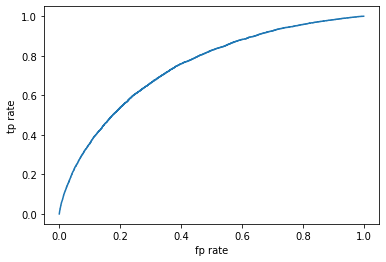

AUC: 0.7441719305334613


,AUC
Linear Regression,0.744172


In [26]:
# アプローチ1検証
X, y = init()
runner = MLRunner01()
X_train, X_test, y_train, y_test = runner.preprocess_train_and_split_train_test(X, y)
ohe_standard_result = runner.train_and_evaluate_model(X_train, X_test, y_train, y_test, LinearRegression(), "Linear Regression")
ohe_standard_result

In [27]:
X_test_preprocessed = runner.preprocess_test(df_test.drop(["SK_ID_CURR"], axis=1))
runner.predict_and_export_result_to_csv(X_test_preprocessed, csv_name="lr_ohe_mean_01")

### 結果
- アプローチ1の結果AUCが向上した

#### アプローチ2 数値データの外れ値を検証

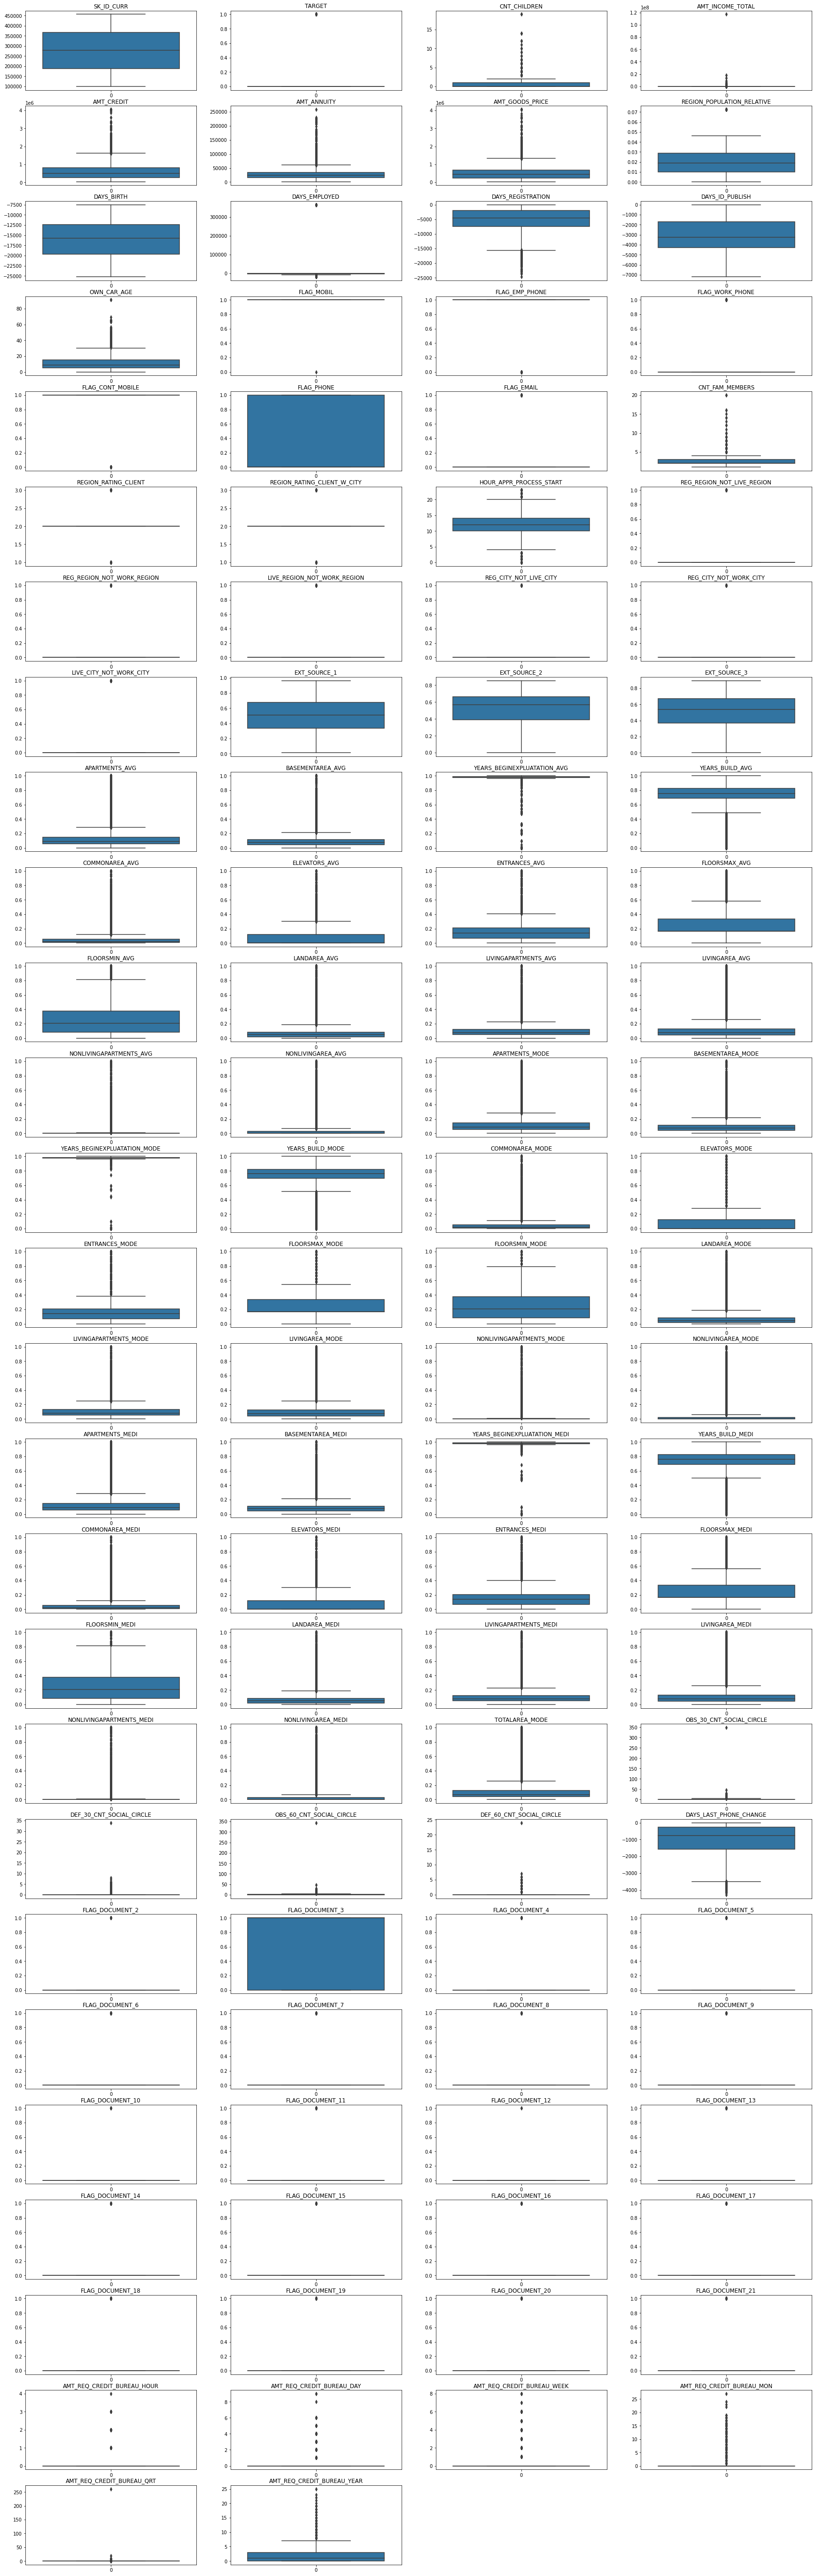

In [28]:
plt.figure(figsize=(30, 100))
for i, col in enumerate(df.select_dtypes(exclude=object).columns):
    r_num = len(df.select_dtypes(exclude=object).columns)
    plt.subplot((r_num / 4) + 1,4,i + 1)
    sns.boxplot(data=df[col])
    plt.title(col)

#### ほぼ全ての項目に外れ値があるので 平均ではなく中央値で数値データの欠損を補完

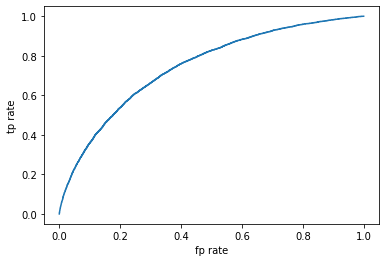

AUC: 0.7444231675095041


,AUC
Linear Regression,0.744423


In [29]:
X, y = init()
runner = MLRunner01(num_missing_imputation="median")
X_train, X_test, y_train, y_test = runner.preprocess_train_and_split_train_test(X, y)
ohe_standard_median_result = runner.train_and_evaluate_model(X_train, X_test, y_train, y_test, LinearRegression(), "Linear Regression")
ohe_standard_median_result

In [30]:
X_test_preprocessed = runner.preprocess_test(df_test.drop(["SK_ID_CURR"], axis=1))
runner.predict_and_export_result_to_csv(X_test_preprocessed, csv_name="lr_ohe_median_01")

### 結果
- アプローチ1に比べるとAUCが向上しなかった

#### アプローチ3 OHEでなくLabel Encodingを使って検証

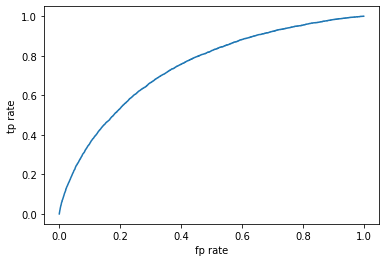

AUC: 0.7432148073309957


,AUC
Linear Regression,0.743215


In [31]:
X, y = init()
runner = MLRunner01(category_encode="label")
X_train, X_test, y_train, y_test = runner.preprocess_train_and_split_train_test(X, y)
label_standard_mean_result = runner.train_and_evaluate_model(X_train, X_test, y_train, y_test, LinearRegression(), "Linear Regression")
label_standard_mean_result

In [32]:
X_test_preprocessed = runner.preprocess_test(df_test.drop(["SK_ID_CURR"], axis=1))
runner.predict_and_export_result_to_csv(X_test_preprocessed, csv_name="lr_label_median_01")

### 結果
- アプローチ1に比べるとAUCが向上しなかった

#### アプローチ4 #min-maxスケーリングで正規化

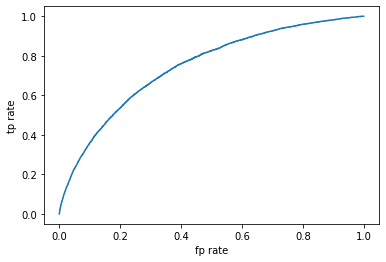

AUC: 0.744736596139259


,AUC
Linear Regression,0.744737


In [33]:
from sklearn.preprocessing import MinMaxScaler
X, y = init()
runner = MLRunner01(scaler=MinMaxScaler())
X_train, X_test, y_train, y_test = runner.preprocess_train_and_split_train_test(X, y)
ohe_minmax_mean_result = runner.train_and_evaluate_model(X_train, X_test, y_train, y_test, LinearRegression(), "Linear Regression")
ohe_minmax_mean_result

In [34]:
X_test_preprocessed = runner.preprocess_test(df_test.drop(["SK_ID_CURR"], axis=1))
runner.predict_and_export_result_to_csv(X_test_preprocessed, csv_name="lr_ohe_MinMaxScaler_01")

### 結果
- 外れ値も多いので、標準化の方が適切だと思ったのだが、アプローチ1に比べるとAUCが向上した。

#### アプローチ5 #Nomalizerで正規化

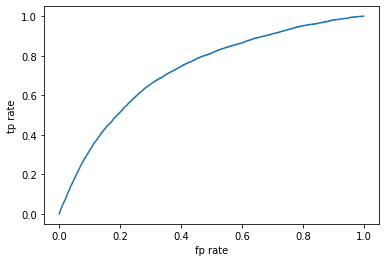

AUC: 0.7295470161141944


,AUC
Linear Regression,0.729547


In [35]:
from sklearn.preprocessing import Normalizer
X, y = init()
runner = MLRunner01(scaler=Normalizer())
X_train, X_test, y_train, y_test = runner.preprocess_train_and_split_train_test(X, y)
ohe_normalizer_mean_result = runner.train_and_evaluate_model(X_train, X_test, y_train, y_test, LinearRegression(), "Linear Regression")
ohe_normalizer_mean_result

In [36]:
X_test_preprocessed = runner.preprocess_test(df_test.drop(["SK_ID_CURR"], axis=1))
runner.predict_and_export_result_to_csv(X_test_preprocessed, csv_name="lr_ohe_Normalizer_01")

#### アプローチ6 #PCA適用

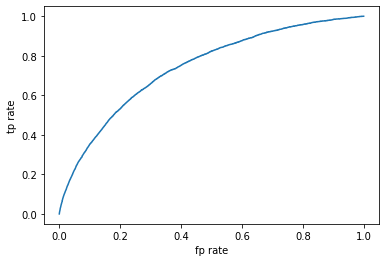

AUC: 0.7413665501812104


,AUC
Linear Regression,0.741367


In [37]:
X, y = init()
runner = MLRunner01(pca=PCA(n_components=200))
X_train, X_test, y_train, y_test = runner.preprocess_train_and_split_train_test(X, y)
ohe_pca_mean_result = runner.train_and_evaluate_model(X_train, X_test, y_train, y_test, LinearRegression(), "Linear Regression")
ohe_pca_mean_result

In [38]:
X_test_preprocessed = runner.preprocess_test(df_test.drop(["SK_ID_CURR"], axis=1))
runner.predict_and_export_result_to_csv(X_test_preprocessed, csv_name="lr_ohe_pca200_01")

#### アプローチ7 #外れ値削除

- 収入に関する外れ値を削除して性能が向上するか確認する

In [39]:
df["AMT_INCOME_TOTAL"].sort_values(ascending=False)

12840     117000000.0
203693     18000090.0
246858     13500000.0
77768       9000000.0
131127      6750000.0
             ...     
240137        26100.0
186643        26100.0
246104        26100.0
20727         25650.0
1678          25650.0
Name: AMT_INCOME_TOTAL, Length: 307511, dtype: float64

一番大きい数である117000000.0は2番手の約10倍のため他に比べて外れ値とし除外する

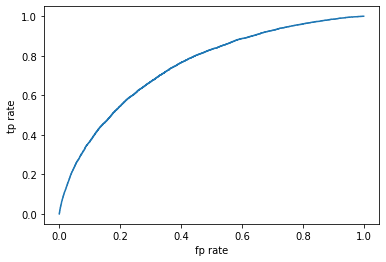

AUC: 0.7493981697780584


,AUC
Linear Regression,0.749398


In [40]:
X, y = init()
# 12840がincome 117000000.0持つ値のため指定して削除
X = X.drop([12840])
y = y.drop([12840])
runner = MLRunner01()
X_train, X_test, y_train, y_test = runner.preprocess_train_and_split_train_test(X, y)
remove_outliner_income_ohe_standard_result = runner.train_and_evaluate_model(X_train, X_test, y_train, y_test, LinearRegression(), "Linear Regression")
remove_outliner_income_ohe_standard_result

結果: INCOMEの外れ値を一つ削除しただけでAUCは向上した。他にも明らかな外れ値があれば削除していくと効果が出るかもしれない

In [41]:
#### アプローチ8: (pendding)featuretoolsを利用して特徴量を増やす

# 実装サンプル
# from woodwork.logical_types import Categorical
# data = {'name': ['a', 'b', 'c'], 'x': [1, 2, 3], 'y': [2, 4, 6],'z': [3, 6, 9]}
# dataset = pd.DataFrame(data)
# dataset
# es = ft.EntitySet(id='example')
# es = es.add_dataframe(dataframe_name='s1', dataframe=dataset, index='name',logical_types={"name": Categorical})
# feature_matrix, features_defs = ft.dfs(entityset = es, target_dataframe_name = 's1', trans_primitives=['add_numeric', 'subtract_numeric'], agg_primitives=[], max_depth=1)
# feature_matrix

## 実装

# get_dummiesによるOHEのため一旦混ぜる
# df_mix = pd.concat([df,df_test])
# cate_columns = [c for c in df_mix.columns if df_mix[c].dtype == 'object']
# df_mix = pd.get_dummies(df_mix, columns=cate_columns)
# import featuretools as ft

# featuretoolsで特徴量を増やす
# es = ft.EntitySet(id='s1')
# es = es.add_dataframe(dataframe_name='mixed', dataframe=df_mix, index='SK_ID_CURR')
# feature_matrix, features_defs = ft.dfs(entityset = es, target_dataframe_name = 'mixed', trans_primitives=['add_numeric'], agg_primitives=[], max_depth=1)
# df_features.reset_index(inplace=True)

# 処理が終わらないので今回はpendding

#### アプローチ9: オーバーサンプリングを行う
- TARGET 1の方が少ないので均等になるようにオーバーサンプリングしてみる

In [43]:
from imblearn.over_sampling import RandomOverSampler
X, y = init()
ros = RandomOverSampler()
print(y.value_counts())
X_resampled, y_resampled = ros.fit_resample(X, y)
print(y_resampled.value_counts())

TARGET
0         282686
1          24825
dtype: int64
TARGET
0         282686
1         282686
dtype: int64


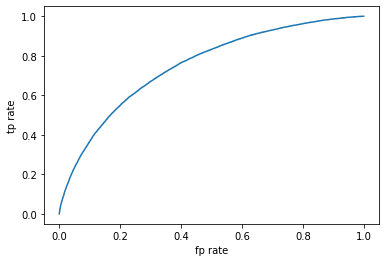

AUC: 0.7506231349141026


,AUC
Linear Regression,0.750623


In [49]:
runner = MLRunner01()
X_train, X_test, y_train, y_test = runner.preprocess_train_and_split_train_test(X_resampled, y_resampled)
over_sampling_ohe_standard_result = runner.train_and_evaluate_model(X_train, X_test, y_train, y_test, LinearRegression(), "Linear Regression")
over_sampling_ohe_standard_result

In [50]:
X_test_preprocessed = runner.preprocess_test(df_test.drop(["SK_ID_CURR"], axis=1))
runner.predict_and_export_result_to_csv(X_test_preprocessed, csv_name="lr_ohe_os_01")

### 結果
- オーバーサンプリングするとAUCは上がった

#### アプローチ10 (おまけ) #xgboost
- 調べていく過程で、xgboost、LightGBMが人気とあったので使ってみた

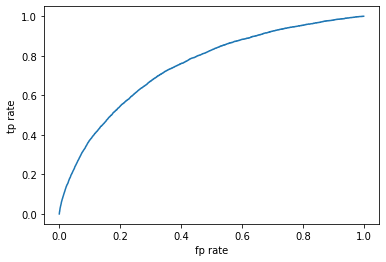

AUC: 0.7471766634992653


,AUC
Linear Regression,0.747177


In [46]:
import xgboost as xgb
X, y = init()
runner = MLRunner01()
X_train, X_test, y_train, y_test = runner.preprocess_train_and_split_train_test(X, y)
xgboost_ohe_mean_result = runner.train_and_evaluate_model(X_train, X_test, y_train, y_test, xgb.XGBRegressor(), "Linear Regression")
xgboost_ohe_mean_result

In [51]:
display("今回試した方法を比較")
pd.DataFrame(
                    {
                        'LinearRegression, OHE, 平均で補完、標準化': ohe_standard_result["AUC"],
                        'LinearRegression, OHE, 中央値で補完、標準化': ohe_standard_median_result["AUC"],
                        'LinearRegression, ラベルエンコーディング, 平均で数値欠損値補完、標準化': label_standard_mean_result["AUC"],
                        'LinearRegression, OHE, 平均で補完、MinMaxScalerで正規化': ohe_minmax_mean_result["AUC"],
                        'LinearRegression, OHE, 平均で補完、Normalizerで正規化': ohe_normalizer_mean_result["AUC"],          
                        "LinearRegression, OHE, 平均で補完, 標準化, PCAで200個に次元削減適用": ohe_pca_mean_result["AUC"],
                        "LinearRegression, OHE, 平均で補完、標準化, INCOMEの外れ値削除": remove_outliner_income_ohe_standard_result["AUC"],
                        "LinearRegression, OHE, 平均で補完、標準化, oversampling適用": over_sampling_ohe_standard_result["AUC"],
                        "XGBRegressor, OHE, 平均で補完、標準化": xgboost_ohe_mean_result["AUC"]
                    }
).T.sort_values(["Linear Regression"], ascending=False)

'今回試した方法を比較'

,Linear Regression
"LinearRegression, OHE, 平均で補完、標準化, oversampling適用",0.750623
"LinearRegression, OHE, 平均で補完、標準化, INCOMEの外れ値削除",0.749398
"XGBRegressor, OHE, 平均で補完、標準化",0.747177
"LinearRegression, OHE, 平均で補完、MinMaxScalerで正規化",0.744737
"LinearRegression, OHE, 中央値で補完、標準化",0.744423
"LinearRegression, OHE, 平均で補完、標準化",0.744172
"LinearRegression, ラベルエンコーディング, 平均で数値欠損値補完、標準化",0.743215
"LinearRegression, OHE, 平均で補完, 標準化, PCAで200個に次元削減適用",0.741367
"LinearRegression, OHE, 平均で補完、Normalizerで正規化",0.729547


kaggleスコア

- LinearRegression, OHE, 平均で補完、標準化, oversampling適用

Score: 0.73585
Public score: 0.74063

- OHE, 平均で補完、標準化

Score: 0.73162
Public score: 0.73668

- OHE, 平均で補完、MinMaxScalerで正規化

Score: 0.73149
Public score: 0.73702

### 考察
- オーバーサンプリングを行うと性能が向上した。
- INCOMEの外れ値を一つ削除しただけで性能が向上した。ざっくりベーs
- 結局項目一つずつに対して検討しなければ傾向は見えないと思える。全体にざっくり適用してもどれが有効かは分からない
- データから特徴を見つけて新しい特徴量を作るというアプローチも入りそう。
- また、実装ミスが起きやすいのでその辺りの防止方法も検討しないといけない。

In [ ]:
# その他2 pandas_profiling使ってEDA(pandding)
# markupsafeの互換性でエラー
# import pandas_profiling
# pandas_profiling.ProfileReport(df)